BBC Datasets: http://mlg.ucd.ie/datasets/bbc.html

Stopwords source: https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js

JS to PY converter: https://pypi.org/project/Js2Py/
                    https://github.com/PiotrDabkowski/Js2Py

converting tensors to numpy arrays: https://www.tensorflow.org/tutorials/customization/basics

Embedding in TF/Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

To visualise (projector) the embeddings and see the sentiment: http://projector.tensorflow.org/

Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Exercise%20-%20Question.ipynb

Answers Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Exercise%20-%20Answer.ipynb

In [0]:
import csv
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

TensorFlow 2.x selected.
2.2.0-rc1
--2020-03-26 21:54:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.06s   

2020-03-26 21:54:48 (80.3 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [0]:
# Hyperparameters:

training_portion = .8

vocab_size = 1000  # YOUR CODE HERE
oov_tok = '<OOV>'  # YOUR CODE HERE

max_length = 120  # YOUR CODE HERE
trunc_type = 'post'  # YOUR CODE HERE
padding_type = 'post'  # YOUR CODE HERE

embedding_dim = 16

In [0]:
# Stopwords to remove from the dataset
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [0]:
# Reading the .csv dataset with pandas

sentences = []
labels = []
# with open("/tmp/bbc-text.csv", 'r') as csvfile:
#     # Your Code here
ds = pd.read_csv('/tmp/bbc-text.csv', sep=',', engine='python')

# Shuffling the data!!!
ds = ds.reindex(np.random.permutation(ds.index))

sentences = ds.iloc[:,1:]  # .values  !!! we don't convert it to numpy array because we actually want to convert the pandas series to a list of strings!!!
labels = ds.iloc[:,0]  # .values

print(sentences.head())
print('')
print(labels.head())


# Converting the pd series to list of strings (each row of the list is a long string with the words of each text)
# sentences = sentences.values.astype(str).tolist()
# labels = labels.values.astype(str).tolist()
sentences = sentences[sentences.columns[0]].astype(str).tolist()  # we convert the series to str and then to a list, skipping to convert it to a np.array (using .values)
labels = labels.astype(str).tolist()



                                                  text
289  sydney to host north v south game sydney will ...
612  profile: gordon brown the ultimate prize of 10...
926  microsoft makes anti-piracy move microsoft say...
117  chancellor rallies labour voters gordon brown ...
44   pandas benefit from wireless net the world s d...

289       sport
612    politics
926        tech
117    politics
44         tech
Name: category, dtype: object


In [0]:
## Removing stop words from the pandas series:

# Function that removes stop words from a list of strings
def remove_stops(strings_list, stop_words):
    strings_list_mod = []
    for line in strings_list :
      for w in stop_words :
        w = ' '+w+' '  # we add spaces in the stop words to not accidentally delete letters that coincide with the stop words inside words
        line = line.replace(w,' ')  # we replace the stop words for a space
        line = line.replace('  ',' ')  # we eliminate possible double spaces
      strings_list_mod.append(line) 
    return strings_list_mod

sentences = remove_stops(sentences, stopwords)


print(len(sentences))
print(sentences[0])
print(type(sentences[0]))

print(len(labels))
print(labels[0])
print(type(labels[0]))

    
# Expected Output
# 2225
# 2225
# tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. might not suit everyone  panel recognised. older generations comfortable familiar schedules channel brands know getting. perhaps not want much choice put hands  mr hanlon suggested.  end  kids just diapers pushing buttons already - everything possible available   said mr hanlon.  ultimately  consumer will tell market want.   50 000 new gadgets technologies showcased ces  many enhancing tv-watching experience. high-definition tv sets everywhere many new models lcd (liquid crystal display) tvs launched dvr capability built  instead external boxes. one example launched show humax s 26-inch lcd tv 80-hour tivo dvr dvd recorder. one us s biggest satellite tv companies  directtv  even launched branded dvr show 100-hours recording capability  instant replay  search function. set can pause rewind tv 90 hours. microsoft chief bill gates announced pre-show keynote speech partnership tivo  called tivotogo  means people can play recorded programmes windows pcs mobile devices. reflect increasing trend freeing multimedia people can watch want  want.

2225
sydney host north v south game sydney will host northern versus southern hemisphere charity match june july australian rugby union (aru) said wednesday. match will include players lions tour new zealand. australian rugby union thrown support behind proposed north-south match raise funds tsunami appeals aru said. date yet decided likely venue sydney s olympic stadium. aru chief executive gary flowers said world cricket charity match melbourne earlier month inspired aru. still need discuss options irb (international rugby board) lions sanzar (south africa new zealand australia rugby) partners june july seen better option march ensure cream southern hemisphere rugby available said. wallabies captain george gregan said charity match great initiative . tri-nations rivals australia new zealand south africa feature prominently southern team northern side comprised six nations teams france ireland england wales italy scotland. coach clive woodward s lions squad will tour new zealand june 

In [0]:
# Splitting the data into train and test sets:

train_size = int(training_portion*len(sentences))  # YOUR CODE HERE

train_sentences = sentences[0:train_size]  # YOUR CODE HERE
train_labels = labels[0:train_size]  # YOUR CODE HERE

validation_sentences = sentences[train_size:]  # YOUR CODE HERE
validation_labels = labels[train_size:]  # YOUR CODE HERE

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 1780
# 1780
# 1780
# 445
# 445

1780
1780
1780
445
445


In [0]:
# Creating the Tokenizer (= vocabulary)

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)  # YOUR CODE HERE
tokenizer.fit_on_texts(train_sentences)  # YOUR CODE HERE)
word_index = tokenizer.word_index  # YOUR CODE HERE

# Tokenizing and padding the training data:
train_sequences = tokenizer.texts_to_sequences(train_sentences)  # YOUR CODE HERE
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)  # YOUR CODE HERE

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

171
120
570
120
227
120


In [0]:
# Tokenizing and Padding the validation data:

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)  # YOUR CODE HERE
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)  # YOUR CODE HERE

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

445
(445, 120)


In [0]:
# Constructing a tokenizer and coding of the labels:

label_tokenizer = Tokenizer(num_words=100) # actual size is 5, no need for oov_token  # YOUR CODE HERE
label_tokenizer.fit_on_texts(train_labels)  # YOUR CODE HERE)
label_word_index = label_tokenizer.word_index

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)  # YOUR CODE HERE
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)  # YOUR CODE HERE

# the tokenized labels needs to be in a numpy arrays to be readable by keras!!!
training_label_seq = np.array(training_label_seq)
validation_label_seq = np.array(validation_label_seq)


print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# To see how many classifications there are:
print(np.max(training_label_seq))
print(np.min(training_label_seq))
print(np.max(validation_label_seq))
print(np.min(validation_label_seq))

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[2]
[3]
[4]
(1780, 1)
[2]
[4]
[5]
(445, 1)
5
1
5
1


In [0]:
model = tf.keras.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),  # tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(24,activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')   # despite labels go from 0 to 5, I guess you have to add the 0 too? 5+1=6 softmax layers
])

model.summary()

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy'])


# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

num_epochs = 50

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.999
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


history = model.fit(
    # YOUR CODE HERE
    train_padded,
    training_label_seq,
    epochs=num_epochs,
    validation_data=(validation_padded,validation_label_seq),
    # callbacks=[callback],
    verbose=2
    )

Epoch 1/50
56/56 - 0s - loss: nan - accuracy: 0.0028 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 8/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 9/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 10/50
56/56 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epo

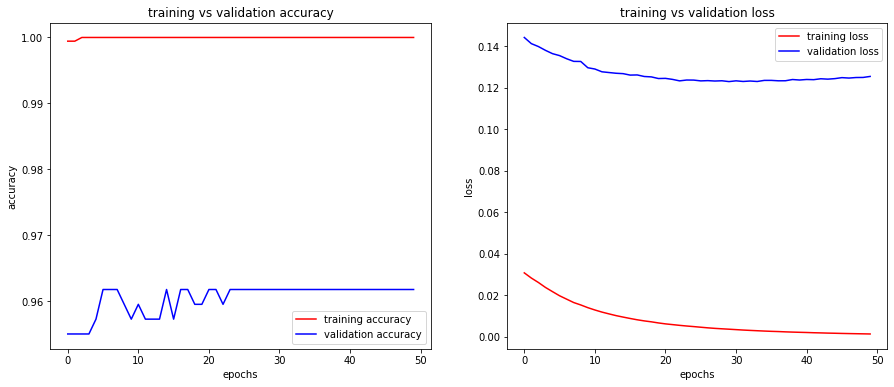

In [0]:
# import matplotlib.pyplot as plt


# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.legend([string, 'val_'+string])
#   plt.show()
  
# plot_graphs(history, "acc")
# plot_graphs(history, "loss")



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')